# GoogLeNet (Inception v1)
GoogLeNet won the LSVRC-2014 competition. It has significant improvement over ZFNet (The winner in 2013) and AlexNet (The winner in 2012) and has relatively lower error rate compared with the VGGNet(1st runner-up in 2014).

### The highlights of the paper
- It contains 1×1 Convolution at the middle of the network. 1×1 convolution is used as a dimension reduction module to reduce the computation. By reducing the computation bottleneck, depth and width can be increased.
- Global average pooling is used at the end of the network instead of using fully connected layers. Global Average can be less prone to overfitting
- Inception module, is to have different sizes/types of convolutions for the same input and stacking all the outputs.
- Local Response Normalization

### The architecture
#### Global average pooling
![gap_layer.png](./images/gap_layer.png)
Global average pooling (GAP) layers to minimize overfitting by reducing the total number of parameters in the model. Similar to max pooling layers, GAP layers are used to reduce the spatial dimensions of a three-dimensional tensor. However, GAP layers perform a more extreme type of dimensionality reduction, where a tensor with dimensions h×w×d is reduced in size to have dimensions 1×1×d. GAP layers reduce each h×w feature map to a single number by simply taking the average of all hw values.

#### Local Response Normalization
This layer is useful when we are dealing with ReLU neurons. Why is that? Because ReLU neurons have unbounded activations and we need LRN to normalize that. We want to detect high frequency features with a large response. If we normalize around the local neighborhood of the excited neuron, it becomes even more sensitive as compared to its neighbors. At the same time, it will dampen the responses that are uniformly large in any given local neighborhood. If all the values are large, then normalizing those values will diminish all of them. So basically we want to encourage some kind of inhibition and boost the neurons with relatively larger activations. 

#### Inception Module
<div width="100%">
    <img src="./images/inception_naive.png" width="40%">
    <img src="./images/inception_reduction.png" width="40%">
<div>
The intention is to let the neural network learn the best weights when training the network and automatically select the more useful features. Additionally, it intends to reduce the no. of dimensions so that the no. of units and layers can be increased at later stages. The side-effect of this is to increase the computational cost for training this layer. To address this, a number of solutions have been suggested in the paper such as to deploy parallel computations for this architecture.

#### Overall Architecture
GoogLeNet has 9 such inception modules stacked linearly. It is 22 layers deep (27, including the pooling layers). It uses global average pooling at the end of the last inception module. To prevent the middle part of the network from “dying out”, the authors introduced two auxiliary classifiers. They essentially applied softmax to the outputs of two of the inception modules, and computed an auxiliary loss over the same labels. The total loss function is a weighted sum of the auxiliary loss and the real loss.

![orignal_architech.png](./images/original_architecture.png)

# GoogLeNet implementation on Cifar 10

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Data Loading and Preprocessing

### CIFAR10 small image classification
Dataset of 50,000 32x32 color training images, labeled over 10 categories, and 10,000 test images.

#### Returns 2 tuples:
- **x_train, x_test**: uint8 array of RGB image data with shape (num_samples, 32, 32, 3).
- **y_train, y_test**: uint8 array of category labels (integers in range 0-9) with shape (num_samples,).

In [2]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
num_classes = 10
print("Number of training examples =", len(x_train))
print("Number of testing examples =", len(x_test))
print("Image data shape =", x_train[0].shape)
print("Number of classes =", num_classes)

Number of training examples = 50000
Number of testing examples = 10000
Image data shape = (32, 32, 3)
Number of classes = 10


In [4]:
x_train = x_train/255.
x_test = x_test/255.

In [5]:
# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

## Model Implementation

In [6]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Input, Activation, BatchNormalization, Flatten, Dropout, Concatenate, AveragePooling2D 
from tensorflow.keras.models import Model

### Model Architecture
The entire model consists of 19 inception layers in total.
![inception_parameters.png](./images/inception_parameters.png)

In [7]:
def inception_module(layer, keys):
    layer_1 = Conv2D(filters=keys['1_conv'], kernel_size=(1, 1), padding='same', activation='relu')(layer)
    
    layer_2 = Conv2D(filters=keys['3_convr'], kernel_size=(1, 1), padding='same', activation='relu')(layer)
    layer_2 = Conv2D(filters=keys['3_conv'], kernel_size=(3, 3), padding='same', activation='relu')(layer_2)
    
    layer_3 = Conv2D(filters=keys['5_convr'], kernel_size=(1, 1), padding='same', activation='relu')(layer)
    layer_3 = Conv2D(filters=keys['5_conv'], kernel_size=(5, 5), padding='same', activation='relu')(layer_3)
    
    layer_4 = MaxPool2D(pool_size=(3, 3), padding='same', strides=(1,1))(layer)
    layer_4 = Conv2D(filters=keys['pool_p'], kernel_size=(1, 1), padding='same', activation='relu')(layer_4)
    
    return Concatenate(axis=3)([layer_1, layer_2, layer_3, layer_4])

In [8]:
inception_keys = {
    "3a" : {
        "1_conv": 64,
        "3_convr": 96,
        "3_conv": 128,
        "5_convr": 16,
        "5_conv": 32,
        "pool_p": 32
    },
    "3b" : {
        "1_conv": 128,
        "3_convr": 128,
        "3_conv": 192,
        "5_convr": 32,
        "5_conv": 96,
        "pool_p": 64
    },
    "4a" : {
        "1_conv": 192,
        "3_convr": 96,
        "3_conv": 208,
        "5_convr": 16,
        "5_conv": 48,
        "pool_p": 64
    },
    "4b" : {
        "1_conv": 160,
        "3_convr": 112,
        "3_conv": 224,
        "5_convr": 24,
        "5_conv": 64,
        "pool_p": 64,
    },
    "4c" : {
        "1_conv": 128,
        "3_convr": 128,
        "3_conv": 256,
        "5_convr": 24,
        "5_conv": 64,
        "pool_p": 64
    },
    "4d" : {
        "1_conv": 112,
        "3_convr": 144,
        "3_conv": 288,
        "5_convr": 32,
        "5_conv": 64,
        "pool_p": 64,
    },
    "4e" : {
        "1_conv": 256,
        "3_convr": 160,
        "3_conv": 320,
        "5_convr": 32,
        "5_conv": 128,
        "pool_p": 128
    },
    "5a" : {
        "1_conv": 256,
        "3_convr": 160,
        "3_conv": 320,
        "5_convr": 32,
        "5_conv": 128,
        "pool_p": 128
    },
    "5b" : {
        "1_conv": 384,
        "3_convr": 192,
        "3_conv": 384,
        "5_convr": 48,
        "5_conv": 128,
        "pool_p": 128
    }
}

In [22]:
def create_model():
    # Input Layer
    inputs = Input(x_train[0].shape)
    
    # Layer 1 Convolution + MaxPooling + BatchNormalization. Ommiting stride (2, 2) due to small size image
    layer_1 = Conv2D(filters=64, kernel_size=(7, 7), padding='same', activation='relu')(inputs)
    layer_1 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(layer_1)
    
    # Layer 2 Convolution 
    layer_2 = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(layer_1)

    # Layer 3 Convolution + MaxPooling
    layer_3 = Conv2D(filters=192, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(layer_2)
    layer_3 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(layer_3)
    
    # Layer 4 Inception 3a
    layer_4 = inception_module(layer_3, inception_keys['3a'])
    
    # Layer 5 Inception 3b
    layer_5 = inception_module(layer_4, inception_keys['3b'])
    
    # Layer 6 Max Pool
    layer_6 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(layer_5)
    
    # Layer 7 Inception 4a
    layer_7 = inception_module(layer_6, inception_keys['4a'])
    
    # Softmax 1
    layer_7_1 = AveragePooling2D(pool_size=(3,3),strides=(3,3))(layer_7)
    
    layer_7_2 = Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu')(layer_7_1)
    
    layer_7_3 = Flatten()(layer_7_2)
    
    layer_7_4 = Dense(units=1024, activation='relu')(layer_7_3)
    
    layer_7_5 = Dropout(rate=0.7)(layer_7_4)
    
    layer_7_6 = Dense(units=10)(layer_7_5)
    
    softmax_1 = Activation(activation='softmax')(layer_7_6)
    
    # Layer 8 Inception 4b
    layer_8 = inception_module(layer_7, inception_keys['4b'])
    
    # Layer 9 Inception 4c
    layer_9 = inception_module(layer_8, inception_keys['4c'])
    
    # Layer 10 Inception 4d
    layer_10 = inception_module(layer_9, inception_keys['4d'])
    
    # Softmax 2
    layer_10_1 = AveragePooling2D(pool_size=(3,3),strides=(3,3))(layer_10)
    
    layer_10_2 = Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu')(layer_10_1)
    
    layer_10_3 = Flatten()(layer_10_2)
    
    layer_10_4 = Dense(units=1024, activation='relu')(layer_10_3)
    
    layer_10_5 = Dropout(rate=0.7)(layer_10_4)
    
    layer_10_6 = Dense(units=10)(layer_10_5)
    
    softmax_2 = Activation(activation='softmax')(layer_10_6)
    
    # Layer 11 Inception 4e
    layer_11 = inception_module(layer_10, inception_keys['4e'])
    
    # Layer 12 Max Pool
    layer_12 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(layer_11)
    
    # Layer 13 Inception 5a
    layer_13 = inception_module(layer_12, inception_keys['5a'])
    
    # Layer 14 Inception 5b
    layer_14 = inception_module(layer_13, inception_keys['5b'])
    
    # Softmax 3
    
    layer_15 = AveragePooling2D(pool_size = (2, 2), strides=(1, 1))(layer_14)
    
    layer_16 = Flatten()(layer_15)
    
    layer_17 = Dropout(rate=0.4)(layer_16)
    
    layer_18 = Dense(units=10)(layer_17)
    
    softmax_3 = Activation(activation='softmax')(layer_18)
    
    model = Model(inputs, outputs=[softmax_1, softmax_2, softmax_3])
    
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [23]:
model = create_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 32, 32, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 16, 16, 64)   0           conv2d_59[0][0]                  
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 16, 16, 64)   4160        max_pooling2d_13[0][0]           
__________________________________________________________________________________________________
conv2d_61 

## Training

In [24]:
model.fit(x=x_train, y=[y_train, y_train, y_train], epochs=10, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 322s 8ms/step - loss: 6.9140 - activation_3_loss: 2.3027 - activation_4_loss: 2.3041 - activation_5_loss: 2.3073 - activation_3_acc: 0.1046 - activation_4_acc: 0.1017 - activation_5_acc: 0.0993 - val_loss: 6.9081 - val_activation_3_loss: 2.3027 - val_activation_4_loss: 2.3027 - val_activation_5_loss: 2.3027 - val_activation_3_acc: 0.1022 - val_activation_4_acc: 0.1025 - val_activation_5_acc: 0.1025
Epoch 2/10
40000/40000 [==============================] - 317s 8ms/step - loss: 6.9094 - activation_3_loss: 2.3034 - activation_4_loss: 2.3032 - activation_5_loss: 2.3028 - activation_3_acc: 0.0970 - activation_4_acc: 0.0986 - activation_5_acc: 0.0965 - val_loss: 6.9083 - val_activation_3_loss: 2.3027 - val_activation_4_loss: 2.3028 - val_activation_5_loss: 2.3028 - val_activation_3_acc: 0.1014 - val_activation_4_acc: 0.1014 - val_activation_5_acc: 0.0952
Epoch 3/10
40000/40000 [======

KeyboardInterrupt: 

## Testing

In [25]:
model.evaluate(x=x_test, y=[y_test, y_test, y_test])

10000/10000 [==============================] - 18s 2ms/step


[6.908085311889648,
 2.3027060218811037,
 2.3026976829528807,
 2.3026815940856933,
 0.1,
 0.1,
 0.1]

In [15]:
model.save('inception_v1_model.h5')
history = model.history

## Results
 
### Training from scratch

Training AlexNet, using stochastic gradient descent with a fixed learning rate of 0.01, for 50 epochs, we acheive a test accuracy of ~76.75%.

In accuracy and loss plot shown below, notice the large gap between the training and testing curves. This suggests that our model is overfitting.

In [23]:
for i in history.history.keys():
    print(i)

val_loss
val_activation_loss
val_activation_1_loss
val_activation_2_loss
val_activation_acc
val_activation_1_acc
val_activation_2_acc
loss
activation_loss
activation_1_loss
activation_2_loss
activation_acc
activation_1_acc
activation_2_acc


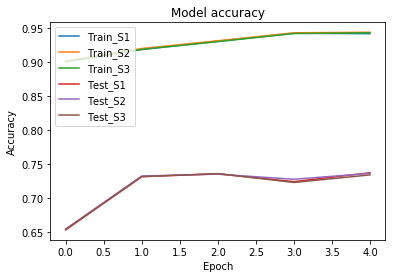

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['activation_acc'])
plt.plot(history.history['activation_1_acc'])
plt.plot(history.history['activation_2_acc'])
plt.plot(history.history['val_activation_acc'])
plt.plot(history.history['val_activation_1_acc'])
plt.plot(history.history['val_activation_2_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_S1', 'Train_S2', 'Train_S3', 'Test_S1', 'Test_S2', 'Test_S3'], loc='upper left')
plt.show()

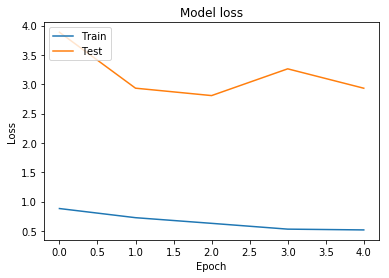

In [17]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Todo
- Expriment to stop model overfiting